In [1]:
import pandas as pd
import numpy as np
from matplotlib.colors import rgb2hex
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import obspy
import matplotlib.patheffects as pe
import matplotlib.ticker as ticker
import calendar
from matplotlib.patches import Rectangle
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from shapely.geometry import box
import geopandas
import cmcrameri.cm as cmc
from cartopy.io import img_tiles
import os
import cartopy.crs as ccrs
from math import floor
import matplotlib
if os.name == 'nt':
    matplotlib.rc('font', family='Arial')
else:  # might need tweaking, must support black triangle for N arrow
    matplotlib.rc('font', family='DejaVu Sans')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.2, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [pe.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [pe.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)

In [3]:
pd.set_option('display.max_rows', 100)

In [4]:
cm_locs = pd.read_excel('../../Data/Creepmeter_list.xlsx')
gdf_Asia = geopandas.read_file("../../Data/GIS_Files/AFEAD_v2022/AFEAD_v2022.shp")
gdf_USA = geopandas.read_file("../../Data/GIS_Files/Shapefile/QFaults.shp")
gdf_Cali = gdf_USA.drop(gdf_USA[gdf_USA.Location!='California'].index)
gdf_Utah = gdf_USA.drop(gdf_USA[gdf_USA.Location!='Utah'].index)

In [5]:
cm_locs.drop(cm_locs[cm_locs['Regular sampling mins']!="Yes"].index,inplace=True)
cm_locs.reset_index(inplace=True,drop=True)


In [6]:
EAF = cm_locs.drop(cm_locs[cm_locs["Network"]!="EAF"].index)
EAF.reset_index(inplace=True,drop=True)
EAF['Creepmeter_abbrv'].iloc[8]='PAN1/PAS1'
EAF.drop([9],inplace=True)
EAF.reset_index(inplace=True,drop=True)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_3879/346536039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EAF['Creepmeter_abbrv'].iloc[8]='PAN1/PAS1'


In [7]:
NAF = cm_locs.drop(cm_locs[cm_locs["Network"]!="NAF"].index)
NAF.reset_index(inplace=True,drop=True)
NAF

Network  Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  Length  \
0     NAF                Cerkes             CER1   40.8947    32.7773    20 m   
1     NAF                Cherry             CHE1   40.8701    32.6285    14 m   
2     NAF           East Sazlik             ESZ1   40.8697    32.6209  25.5 m   
3     NAF               Hamamli             HAM1   40.8729    32.6603    13 m   
4     NAF  Ismetpasa North Wall             INW1   40.8698    32.6258  16.5 m   
5     NAF  Ismetpasa South Wall             ISW1   40.8697    32.6258    20 m   
6     NAF                Petrol             PET1   40.8657    32.5976    14 m   
7     NAF                Seller             SEL1   40.7209    29.9720    16 m   
8     NAF             Tepetarla             TEP1   40.7210    30.0784  18.1 m   
9     NAF           West Sazlik             WSZ1   40.8692    32.6194    30 m   

  Depth Obliquity Sensor Type Rod type notes Regular sampling mins Daily  \
0   NaN        29         NaN      NaN   NaN                   Yes    No   
1   NaN        35         NaN      NaN   NaN                   Yes    No   
2   NaN        28         NaN      NaN   NaN                   Yes    No   
3   NaN        30         NaN      NaN   NaN                   Yes    No   
4   NaN        30         NaN      NaN   NaN                   Yes    No   
5   NaN        30         NaN      NaN   NaN                   Yes    No   
6   NaN        30         NaN      NaN   NaN                   Yes    No   
7   NaN        30         NaN      NaN   NaN                   Yes    No   
8   NaN        38         NaN      NaN   NaN                   Yes    No   
9   NaN        30         NaN      NaN   NaN                   Yes    No   

  Manual Temp orthogonal voltage   IR ortho V  
0     No  Yes         No      No   No      No  
1     No  Yes         No      No   No      No  
2     No  Yes         No      No   No      No  
3     No   No         No      No   No      No  
4     No   No         No      No   No      No  
5     No   No         No      No   No      No  
6     No   No         No      No   No      No  
7     No   No         No      No   No      No  
8     No   No         No      No   No      No  
9     No  Yes         No      No  Yes      No

In [8]:
PARK = cm_locs.drop(cm_locs[cm_locs["Network"]!="PARK"].index)
PARK.reset_index(inplace=True,drop=True)
PARK['Creepmeter_abbrv'].iloc[0] = 'C461/2'
PARK['Creepmeter_abbrv'].iloc[11] = 'XPK1/2'
PARK.drop([1,3,8,12],inplace=True)
PARK.reset_index(inplace=True,drop=True)
PARK

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_3879/3190859939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PARK['Creepmeter_abbrv'].iloc[0] = 'C461/2'
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_3879/3190859939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PARK['Creepmeter_abbrv'].iloc[11] = 'XPK1/2'


Network Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  Length  \
0     PARK           Highway 46           C461/2    35.724   -120.282     NaN   
1     PARK           Carr Ranch             CRR1    35.835   -120.363   9.4 m   
2     PARK           Work Ranch             WKR1    35.858   -120.392    14 m   
3     PARK           Highway 46             X461    35.723   -120.278    27 m   
4     PARK            Gold Hill             XGH1    35.820   -120.348    10 m   
5     PARK     Hearst, SW trace             XHSW    35.862   -120.420    30 m   
6     PARK         Middle Ridge             XMD1    35.943   -120.485    36 m   
7     PARK           Middle Mtn             XMM1    35.958   -120.502    26 m   
8     PARK         Parkfield #1           XPK1/2    35.902   -120.442    23 m   
9     PARK   Roberson, SW trace             XRSW    35.907   -120.460    30 m   
10    PARK        Slacks Canyon             XSC1    36.065   -120.628    10 m   
11    PARK         Taylor Ranch             XTA1    35.890   -120.427    30 m   
12    PARK               Varian             XVA1    35.922   -120.462    30 m   

   Depth Obliquity     Sensor Type Rod type                       notes  \
0    NaN        30       Bilham #1    Invar                         NaN   
1    1 m        45  Caltech Design     wire                         NaN   
2    1 m        45  Caltech Design     wire                         NaN   
3    1 m       -44   USGS standard      NaN  contraction is dexral slip   
4     cm        30   USGS standard     wire                         NaN   
5    NaN        45   USGS standard     wire                         NaN   
6    1 m        27   USGS standard     wire                         NaN   
7    1 m        30   USGS standard     wire                         NaN   
8    1 m        30   USGS standard     wire                         NaN   
9    NaN        30   USGS standard     wire                         NaN   
10    cm        27   USGS standard     wire                         NaN   
11   1 m        30   USGS standard     wire                         NaN   
12   1 m        30   USGS standard     wire                         NaN   

   Regular sampling mins Daily Manual Temp orthogonal voltage  IR ortho V  
0                    Yes    No     No   No         No      No  No      No  
1                    Yes   Yes    Yes   No         No      No  No      No  
2                    Yes   Yes    Yes   No         No      No  No      No  
3                    Yes   Yes    Yes   No         No      No  No      No  
4                    Yes   Yes    Yes   No         No      No  No      No  
5                    Yes   Yes    Yes   No         No      No  No      No  
6                    Yes   Yes    Yes   No         No      No  No      No  
7                    Yes   Yes    Yes   No         No      No  No      No  
8                    Yes   Yes    Yes   No         No      No  No      No  
9                    Yes   Yes    Yes   No         No      No  No      No  
10                   Yes   Yes    Yes   No         No      No  No      No  
11                   Yes   Yes    Yes   No         No      No  No      No  
12                   Yes   Yes    Yes   No         No      No  No      No

In [9]:
HAY = cm_locs.drop(cm_locs[cm_locs["Network"]!="HAY"].index)
HAY.reset_index(inplace=True,drop=True)
HAY

Network     Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  \
0     HAY           Fremont Winery             CFW1    37.532   -121.952   
1     HAY  Hayward Palisades St #2             CHP1    37.663   -122.074   
2     HAY              Oakland Zoo             COZ1    37.753   -122.150   
3     HAY                Pt Pinole             CPP1    37.990   -122.356   
4     HAY                 Temescal             CTM1    37.844   -122.227   

  Length  Depth Obliquity Sensor Type  \
0   25 m    1 m        30        LVDT   
1   20 m    1 m        30        LVDT   
2   30 m  1.5 m        30        LVDT   
3   30 m   2  m        30        LVDT   
4   30 m    1 m        30        LVDT   

                                            Rod type notes  \
0  silica-glass fiber and invar (two separate int...   NaN   
1                              invar now glass fiber   NaN   
2                             glass and carbon fiber   NaN   
3  Initially Invar. Changed to 5mm diameter carbo...   NaN   
4                            Invar, now carbon fiber   NaN   

  Regular sampling mins Daily Manual Temp orthogonal voltage  IR ortho V  
0                   Yes    No     No   No         No      No  No      No  
1                   Yes    No     No   No         No      No  No      No  
2                   Yes    No     No   No         No      No  No      No  
3                   Yes    No     No   No         No      No  No      No  
4                   Yes    No     No   No         No      No  No      No

In [10]:
HOL = cm_locs.drop(cm_locs[cm_locs["Network"]!="HOL"].index)
HOL.reset_index(inplace=True,drop=True)
HOL['Creepmeter_abbrv'].iloc[0] = 'CWN1/CWC3'
HOL['Creepmeter_abbrv'].iloc[4] = 'XHR1/2/3'
HOL['Creepmeter_abbrv'].iloc[8] = 'XSJ2/3'
HOL.drop([1,5,6,9],inplace=True)
HOL.reset_index(inplace=True,drop=True)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_3879/2495391497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOL['Creepmeter_abbrv'].iloc[0] = 'CWN1/CWC3'
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_3879/2495391497.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOL['Creepmeter_abbrv'].iloc[4] = 'XHR1/2/3'
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_3879/2495391497.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [11]:
RID = cm_locs.drop(cm_locs[cm_locs["Network"]!="RID"].index)
RID.reset_index(inplace=True,drop=True)
RID

Network Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  Length  \
0     RID        GB Ridgecrest               GB   35.5239  -117.3731     4 m   
1     RID        GD Ridgecrest               GD   35.4434  -117.6832     8 m   
2     RID        GS Ridgecrest               GS   35.5022  -117.4678  10.5 m   
3     RID        GT Ridgecrest               GT   35.4695  -117.5919   9.8 m   
4     RID        R7 Ridgecrest               R7   35.5960  -117.4019     4 m   
5     RID        RA Ridgecrest               RA   35.6189  -117.5722     2 m   
6     RID        RB Ridgecrest               RB   35.6189  -117.5722    14 m   

  Depth Obliquity Sensor Type Rod type notes Regular sampling mins Daily  \
0   NaN        30         NaN      NaN   NaN                   Yes    No   
1   NaN        30         NaN      NaN   NaN                   Yes   NaN   
2   NaN        30         NaN      NaN   NaN                   Yes    No   
3   NaN        30         NaN      NaN   NaN                   Yes   NaN   
4   NaN        35         NaN      NaN   NaN                   Yes    No   
5   NaN        30         NaN      NaN   NaN                   Yes    No   
6   NaN        30         NaN      NaN   NaN                   Yes    No   

  Manual Temp orthogonal voltage   IR ortho V  
0     No   No         No      No   No      No  
1    NaN  NaN        NaN     NaN  NaN     NaN  
2     No   No         No      No   No      No  
3    NaN  NaN        NaN     NaN  NaN     NaN  
4     No   No         No      No   No      No  
5     No   No         No      No   No      No  
6     No   No         No      No   No      No

In [12]:
CHAF = cm_locs.drop(cm_locs[cm_locs["Network"]!="CHAF"].index)
CHAF.reset_index(inplace=True,drop=True)
CHAF

Network Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude Length  \
0    CHAF               Chaman             CHA1   30.8925    66.5334   15 m   

  Depth Obliquity Sensor Type Rod type notes Regular sampling mins Daily  \
0   NaN        30         NaN      NaN   NaN                   Yes    No   

  Manual Temp orthogonal voltage  IR ortho V  
0     No   No         No      No  No      No

In [13]:
CAL = cm_locs.drop(cm_locs[cm_locs["Network"]!="CAL"].index)
CAL.reset_index(inplace=True,drop=True)
CAL

Network Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude Length  \
0     CAL          Shore Rd #1             XSH1    36.943   -121.445   14 m   

  Depth Obliquity    Sensor Type Rod type notes Regular sampling mins Daily  \
0   NaN      41.5  USGS standard      NaN   NaN                   Yes   Yes   

  Manual Temp orthogonal voltage  IR ortho V  
0    Yes   No         No      No  No      No

In [14]:
HOL = pd.concat([HOL,CAL],ignore_index=True)

In [15]:
UTA = cm_locs.drop(cm_locs[cm_locs["Network"]!="UTA"].index)
UTA.reset_index(inplace=True,drop=True)
UTA

Network Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude Length  \
0     UTA          Canyonlands             CAN1   38.0198  -110.0374  7.5 m   

  Depth Obliquity Sensor Type Rod type notes Regular sampling mins Daily  \
0   NaN        45         NaN      NaN   NaN                   Yes    No   

  Manual Temp orthogonal voltage  IR ortho V  
0     No  Yes         No      No  No      No

In [16]:
SOCAL= cm_locs.drop(cm_locs[cm_locs["Network"]!="SOCAL"].index)
SOCAL.reset_index(inplace=True,drop=True)
SOCAL['Creepmeter_abbrv'].iloc[7] = 'SC30/72/TE'
SOCAL['Creepmeter_abbrv'].iloc[10] = 'SH30/90'
SOCAL['Creepmeter_abbrv'].iloc[12] = 'SU30C/I'
SOCAL.drop([8,9,11,13],inplace=True)
SOCAL.reset_index(inplace=True,drop=True)
SOCAL

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_3879/2404677308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOCAL['Creepmeter_abbrv'].iloc[7] = 'SC30/72/TE'
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_3879/2404677308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOCAL['Creepmeter_abbrv'].iloc[10] = 'SH30/90'
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_3879/2404677308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Network         Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  \
0   SOCAL     Pipeline SSA Durmid Hill             DU30   33.4120  -115.7950   
1   SOCAL       Ferrum SSA Durmid Hill             FE30   33.4572  -115.8539   
2   SOCAL  Indian Ring SSA North Shore             IR30   33.5700  -115.9785   
3   SOCAL  North Shore SSA North Shore             NS45   33.5307  -115.9388   
4   SOCAL    E. Quarry SSA Mecca Hills             QE30   33.6473  -116.0780   
5   SOCAL    W. Quarry SSA Mecca Hills             QW30   33.6526  -116.0846   
6   SOCAL          Ross Road, Imperial             RR45   32.7812  -115.4485   
7   SOCAL       Salt Creek SSA oblique       SC30/72/TE   33.4485  -115.8437   
8   SOCAL      North Shoreline oblique          SH30/90   33.3713  -115.7808   
9   SOCAL           Superstition Hills          SU30C/I   32.9303  -115.7009   

   Length Depth Obliquity Sensor Type Rod type notes Regular sampling mins  \
0    14 m   NaN        30         NaN      NaN   NaN                   Yes   
1     9 m   NaN        30         NaN      NaN   NaN                   Yes   
2    10 m   NaN        30         NaN      NaN   NaN                   Yes   
3    14 m   NaN        45         NaN      NaN   NaN                   Yes   
4    10 m   NaN        30         NaN      NaN   NaN                   Yes   
5     8 m   NaN        30         NaN      NaN   NaN                   Yes   
6    16 m   NaN        45         NaN      NaN   NaN                   Yes   
7  12.8 m   NaN        30         NaN      NaN   NaN                   Yes   
8    13 m   NaN        30         NaN      NaN   NaN                   Yes   
9     7 m   NaN        30         NaN      NaN   NaN                   Yes   

  Daily Manual Temp orthogonal voltage   IR ortho V  
0   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
1   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
2   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
3   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
4   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
5   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
6   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
7   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
8   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
9   NaN    NaN  NaN        NaN     NaN  NaN     NaN

In [17]:

SOCAL.sort_values(by='Latitude',inplace=True)
SOCAL

Network         Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  \
6   SOCAL          Ross Road, Imperial             RR45   32.7812  -115.4485   
9   SOCAL           Superstition Hills          SU30C/I   32.9303  -115.7009   
8   SOCAL      North Shoreline oblique          SH30/90   33.3713  -115.7808   
0   SOCAL     Pipeline SSA Durmid Hill             DU30   33.4120  -115.7950   
7   SOCAL       Salt Creek SSA oblique       SC30/72/TE   33.4485  -115.8437   
1   SOCAL       Ferrum SSA Durmid Hill             FE30   33.4572  -115.8539   
3   SOCAL  North Shore SSA North Shore             NS45   33.5307  -115.9388   
2   SOCAL  Indian Ring SSA North Shore             IR30   33.5700  -115.9785   
4   SOCAL    E. Quarry SSA Mecca Hills             QE30   33.6473  -116.0780   
5   SOCAL    W. Quarry SSA Mecca Hills             QW30   33.6526  -116.0846   

   Length Depth Obliquity Sensor Type Rod type notes Regular sampling mins  \
6    16 m   NaN        45         NaN      NaN   NaN                   Yes   
9     7 m   NaN        30         NaN      NaN   NaN                   Yes   
8    13 m   NaN        30         NaN      NaN   NaN                   Yes   
0    14 m   NaN        30         NaN      NaN   NaN                   Yes   
7  12.8 m   NaN        30         NaN      NaN   NaN                   Yes   
1     9 m   NaN        30         NaN      NaN   NaN                   Yes   
3    14 m   NaN        45         NaN      NaN   NaN                   Yes   
2    10 m   NaN        30         NaN      NaN   NaN                   Yes   
4    10 m   NaN        30         NaN      NaN   NaN                   Yes   
5     8 m   NaN        30         NaN      NaN   NaN                   Yes   

  Daily Manual Temp orthogonal voltage   IR ortho V  
6   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
9   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
8   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
0   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
7   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
1   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
3   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
2   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
4   NaN    NaN  NaN        NaN     NaN  NaN     NaN  
5   NaN    NaN  NaN        NaN     NaN  NaN     NaN

In [18]:
hollister_extent = [-121.75,-121.0,36.5,37.0]
hayward_extent = [-122.4,-121.8,37.5,38.1]
parkfield_extent = [-120.75,-120.1,35.65,36.1]
salton_sea_extent = [-116.25,-115.25,32.5,33.75]
pakistan_extent = [61, 78, 23, 38]

cmap = cmc.managua
slicedCM = cmap(np.linspace(0, 1, len(SOCAL)))

print(SOCAL)

color_dict = {'creepmeter':{'DU30':rgb2hex(slicedCM[3]),
                            'FE30':rgb2hex(slicedCM[4]),
                            'IR30':rgb2hex(slicedCM[7]),
                            'NS45':rgb2hex(slicedCM[6]),
                            'QE30':rgb2hex(slicedCM[8]),
                            'QW30':rgb2hex(slicedCM[9]),
                            'RR45':rgb2hex(slicedCM[0]),
                            'SC30/72/TE':rgb2hex(slicedCM[4]),
                            'SH30/90':rgb2hex(slicedCM[2]),
                            'SU30C/I':rgb2hex(slicedCM[1])}}

  Network         Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  \
6   SOCAL          Ross Road, Imperial             RR45   32.7812  -115.4485   
9   SOCAL           Superstition Hills          SU30C/I   32.9303  -115.7009   
8   SOCAL      North Shoreline oblique          SH30/90   33.3713  -115.7808   
0   SOCAL     Pipeline SSA Durmid Hill             DU30   33.4120  -115.7950   
7   SOCAL       Salt Creek SSA oblique       SC30/72/TE   33.4485  -115.8437   
1   SOCAL       Ferrum SSA Durmid Hill             FE30   33.4572  -115.8539   
3   SOCAL  North Shore SSA North Shore             NS45   33.5307  -115.9388   
2   SOCAL  Indian Ring SSA North Shore             IR30   33.5700  -115.9785   
4   SOCAL    E. Quarry SSA Mecca Hills             QE30   33.6473  -116.0780   
5   SOCAL    W. Quarry SSA Mecca Hills             QW30   33.6526  -116.0846   

   Length Depth Obliquity Sensor Type Rod type notes Regular sampling mins  \
6    16 m   NaN        45         NaN    

/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


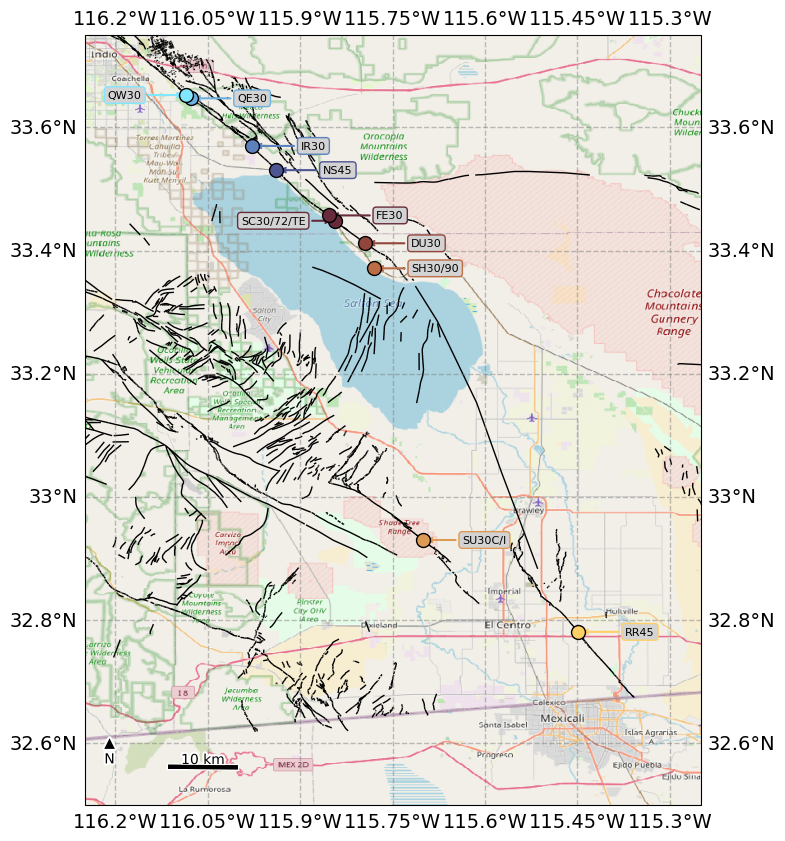

In [20]:
fig = plt.figure(figsize=(10, 10))

axa= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
axa.add_image(osm, 10)  # Zoom level of 8 
axa.set_extent(salton_sea_extent, crs=ccrs.PlateCarree())
axa.add_geometries(gdf_Cali.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
gl = axa.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
gl.ylabel_style = {'size': 14}
shift='horizontal'

for i in range(len(SOCAL)):
    face_color = color_dict['creepmeter'][SOCAL['Creepmeter_abbrv'].iloc[i]]
    # Default xytext offset
    if shift == 'horizontal':
        # Adjust xytext for specific creepmeter abbreviations
        if SOCAL['Creepmeter_abbrv'].iloc[i] in ['XRSW', 'XTA1','XHSW', 'C461','CWN1/CWC3','CRR1','XMM1','QW30','SC30/72/TE']:
            xytext_lon = SOCAL['Longitude'].iloc[i] - 0.1  # Subtract 0.1 for these specific abbreviations
        else:
            xytext_lon = SOCAL['Longitude'].iloc[i] + 0.1
        xytext_lat = SOCAL['Latitude'].iloc[i]
    if shift == 'vertical':
        xytext_lon = SOCAL['Longitude'].iloc[i] 
        xytext_lat = SOCAL['Latitude'].iloc[i] - 1
    
    
    
    axa.annotate(
        SOCAL['Creepmeter_abbrv'].iloc[i], 
        xy=(SOCAL['Longitude'].iloc[i], SOCAL['Latitude'].iloc[i]),
        xytext=(xytext_lon, xytext_lat), 
        arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
        fontsize=8, ha='center', va='center',
        transform=ccrs.PlateCarree()  # Make sure coordinates are correct
    )
    # Scatter points for creepmeters
    axa.scatter(
        SOCAL['Longitude'].iloc[i], 
        SOCAL['Latitude'].iloc[i], 
        color=face_color, 
        edgecolor='black', 
        s=100, 
        zorder=100, 
        transform=ccrs.Geodetic()
    )
scale_bar(axa, ccrs.PlateCarree(), 10)
plt.savefig('SoCal_map.pdf')
plt.show()

In [21]:
EAF.sort_values(by='Latitude',inplace=True)
EAF

Network Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  \
6      EAF             Kirikhan             KIR1   36.4791    36.3339   
3      EAF                Hassa             HAS1   36.8006    36.5185   
0      EAF           Balikburnu             BAL1   37.9903    38.1990   
1      EAF               Goksun             GOK1   38.0060    36.5267   
5      EAF             Karakose             KAR1   38.0697    38.4983   
12     EAF          Yazica West             YZW1   38.1086    38.7361   
2      EAF               Gozene             GOZ1   38.1759    38.0103   
11     EAF          Yazica East             YZE1   38.1791    38.7526   
10     EAF               Tasmis             TAS1   38.2049    38.7872   
7      EAF             Ormanice             ORM1   38.2113    38.7732   
4      EAF                Hatay             HAT1   38.3870    36.2803   
9      EAF              Sivrice             SIV1   38.3880    39.1873   
8      EAF           Palu North        PAN1/PAS1   38.6990    39.9537   

                Length Depth Obliquity Sensor Type Rod type notes  \
6                  5 m   NaN        30         NaN      NaN   NaN   
3                  5 m   NaN        30         NaN      NaN   NaN   
0                  5 m   NaN        30         NaN      NaN   NaN   
1                  6 m   NaN        30         NaN      NaN   NaN   
5                  6 m   NaN        30         NaN      NaN   NaN   
12                 5 m   NaN        35         NaN      NaN   NaN   
2                  5 m   NaN        30         NaN      NaN   NaN   
11                20 m   NaN        30         NaN      NaN   NaN   
10  52 (originally 9m)   NaN        30         NaN      NaN   NaN   
7                 16 m   NaN        30         NaN      NaN   NaN   
4                 26 m   NaN        30         NaN      NaN   NaN   
9                 16 m   NaN        30         NaN      NaN   NaN   
8                  8 m   NaN        30         NaN      NaN   NaN   

   Regular sampling mins Daily Manual Temp orthogonal voltage  IR ortho V  
6                    Yes    No     No  Yes         No      No  No      No  
3                    Yes    No     No   No         No      No  No      No  
0                    Yes    No     No  Yes         No      No  No      No  
1                    Yes    No     No  Yes        Yes      No  No      No  
5                    Yes    No     No  Yes        Yes     Yes  No     Yes  
12                   Yes    No     No  Yes         No      No  No      No  
2                    Yes    No     No  Yes         No      No  No      No  
11                   Yes    No     No  Yes         No      No  No      No  
10                   Yes    No     No  Yes         No      No  No      No  
7                    Yes    No     No  Yes         No      No  No      No  
4                    Yes    No     No   No         No      No  No      No  
9                    Yes    No     No  Yes         No      No  No      No  
8                    Yes    No     No  Yes         No     Yes  No      No

In [51]:
cmap = cmc.managua
slicedCM = cmap(np.linspace(0, 1, len(EAF)+1))

EAF.sort_values(by='Latitude')

color_dict = {'creepmeter':{'BAL1':rgb2hex(slicedCM[2]),
                            'GOK1':rgb2hex(slicedCM[3]),
                            'GOZ1':rgb2hex(slicedCM[6]),
                            'HAS1':rgb2hex(slicedCM[1]),
                            'HAT1':rgb2hex(slicedCM[10]),
                            'KAR1':rgb2hex(slicedCM[4]),
                            'KIR1':rgb2hex(slicedCM[0]),
                            'ORM1':rgb2hex(slicedCM[9]),
                            'PAN1/PAS1':rgb2hex(slicedCM[12]),
                            'SIV1':rgb2hex(slicedCM[11]),
                            'TAS1':rgb2hex(slicedCM[8]),
                            'YZE1':rgb2hex(slicedCM[7]),
                            'YZW1':rgb2hex(slicedCM[5])}}

EAF_extent = [36.0, 40.25, 36.0, 39]
slicedCM = cmap(np.linspace(0, 1, 15))
for i in range(len(slicedCM)):
    print(rgb2hex(slicedCM[i]))

#ffcf67
#e9ac5b
#d38c51
#bd7047
#a4553f
#893e3a
#6d2d3a
#572949
#4d3566
#4d4c88
#5367a7
#5d85c0
#68a3d5
#74c4ea
#81e7ff


/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


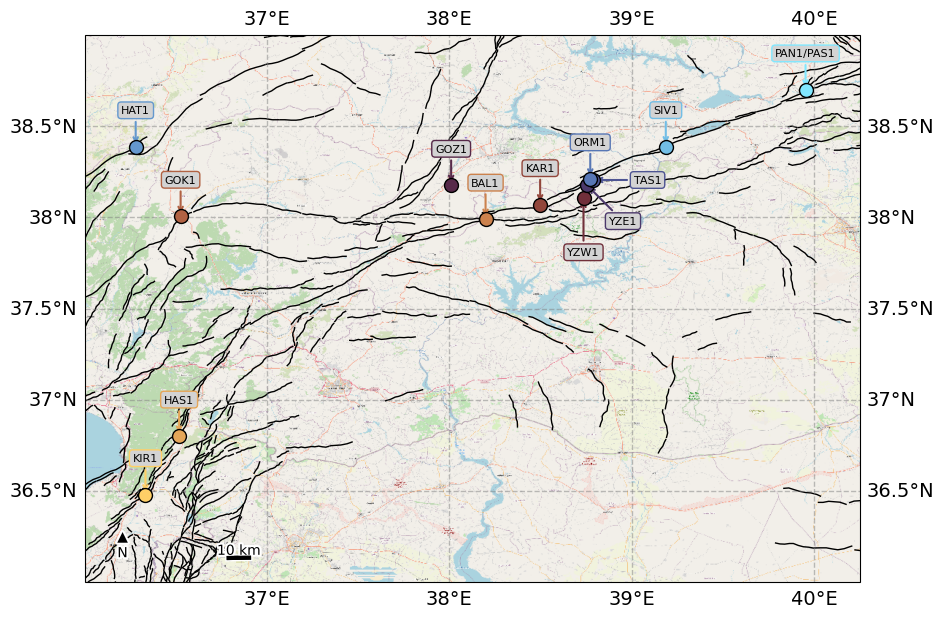

In [23]:
fig = plt.figure(figsize=(10, 10))

axa= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
axa.add_image(osm, 10)  # Zoom level of 8 
axa.set_extent(EAF_extent, crs=ccrs.PlateCarree())
axa.add_geometries(gdf_Asia.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
gl = axa.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
gl.ylabel_style = {'size': 14}
shift='vertical'

for i in range(len(EAF)):
    face_color = color_dict['creepmeter'][EAF['Creepmeter_abbrv'].iloc[i]]
    # Default xytext offset
    if shift == 'horizontal':
        # Adjust xytext for specific creepmeter abbreviations
        if EAF['Creepmeter_abbrv'].iloc[i] in ['XRSW', 'XTA1','XHSW', 'C461','CWN1/CWC3','CRR1','XMM1','QW30','SC30/72/TE']:
            xytext_lon = EAF['Longitude'].iloc[i] - 0.1  # Subtract 0.1 for these specific abbreviations
        else:
            xytext_lon = EAF['Longitude'].iloc[i] + 0.1
        xytext_lat = EAF['Latitude'].iloc[i]
    if shift == 'vertical':
        xytext_lon = EAF['Longitude'].iloc[i] 
        xytext_lat = EAF['Latitude'].iloc[i] + 0.2
        if EAF['Creepmeter_abbrv'].iloc[i] in ['TAS1']:
            xytext_lon = EAF['Longitude'].iloc[i]+0.3
            xytext_lat = EAF['Latitude'].iloc[i]
        if EAF['Creepmeter_abbrv'].iloc[i] in ['YZW1']:
            xytext_lon = EAF['Longitude'].iloc[i]
            xytext_lat = EAF['Latitude'].iloc[i]-0.3
        if EAF['Creepmeter_abbrv'].iloc[i] in ['YZE1']:
            xytext_lon = EAF['Longitude'].iloc[i]+0.2
            xytext_lat = EAF['Latitude'].iloc[i]-0.2
    
    
    axa.annotate(
        EAF['Creepmeter_abbrv'].iloc[i], 
        xy=(EAF['Longitude'].iloc[i], EAF['Latitude'].iloc[i]),
        xytext=(xytext_lon, xytext_lat), 
        arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
        fontsize=8, ha='center', va='center',
        transform=ccrs.PlateCarree()  # Make sure coordinates are correct
    )
    # Scatter points for creepmeters
    axa.scatter(
        EAF['Longitude'].iloc[i], 
        EAF['Latitude'].iloc[i], 
        color=face_color, 
        edgecolor='black', 
        s=100, 
        zorder=100, 
        transform=ccrs.Geodetic()
    )
scale_bar(axa, ccrs.PlateCarree(), 10)
plt.savefig('EAF_map.pdf')
plt.show()

In [24]:
NAF = cm_locs.drop(cm_locs[cm_locs["Network"]!="NAF"].index)

NAF.sort_values(by='Longitude',inplace=True)
NAF.reset_index(inplace=True,drop=True)
NAF.drop([0,1],inplace=True)

NAF

Network  Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  Length  \
2     NAF                Petrol             PET1   40.8657    32.5976    14 m   
3     NAF           West Sazlik             WSZ1   40.8692    32.6194    30 m   
4     NAF           East Sazlik             ESZ1   40.8697    32.6209  25.5 m   
5     NAF  Ismetpasa North Wall             INW1   40.8698    32.6258  16.5 m   
6     NAF  Ismetpasa South Wall             ISW1   40.8697    32.6258    20 m   
7     NAF                Cherry             CHE1   40.8701    32.6285    14 m   
8     NAF               Hamamli             HAM1   40.8729    32.6603    13 m   
9     NAF                Cerkes             CER1   40.8947    32.7773    20 m   

  Depth Obliquity Sensor Type Rod type notes Regular sampling mins Daily  \
2   NaN        30         NaN      NaN   NaN                   Yes    No   
3   NaN        30         NaN      NaN   NaN                   Yes    No   
4   NaN        28         NaN      NaN   NaN                   Yes    No   
5   NaN        30         NaN      NaN   NaN                   Yes    No   
6   NaN        30         NaN      NaN   NaN                   Yes    No   
7   NaN        35         NaN      NaN   NaN                   Yes    No   
8   NaN        30         NaN      NaN   NaN                   Yes    No   
9   NaN        29         NaN      NaN   NaN                   Yes    No   

  Manual Temp orthogonal voltage   IR ortho V  
2     No   No         No      No   No      No  
3     No  Yes         No      No  Yes      No  
4     No  Yes         No      No   No      No  
5     No   No         No      No   No      No  
6     No   No         No      No   No      No  
7     No  Yes         No      No   No      No  
8     No   No         No      No   No      No  
9     No  Yes         No      No   No      No

In [25]:
cmap = cmc.managua
slicedCM = cmap(np.linspace(0, 1, len(NAF)))


color_dict = {'creepmeter':{'SEL1':rgb2hex(slicedCM[0]),
                            'TEP1':rgb2hex(slicedCM[1]),
                            'PET1':rgb2hex(slicedCM[0]),
                            'WSZ1':rgb2hex(slicedCM[1]),
                            'ESZ1':rgb2hex(slicedCM[2]),
                            'ISW1':rgb2hex(slicedCM[3]),
                            'INW1':rgb2hex(slicedCM[4]),
                            'CHE1':rgb2hex(slicedCM[5]),
                            'HAM1':rgb2hex(slicedCM[6]),
                            'CER1':rgb2hex(slicedCM[7])}}
NAF_extent = [29.5, 33,40, 41]
NAF_extent_inset = [32.5, 32.8,40.8, 41]

/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


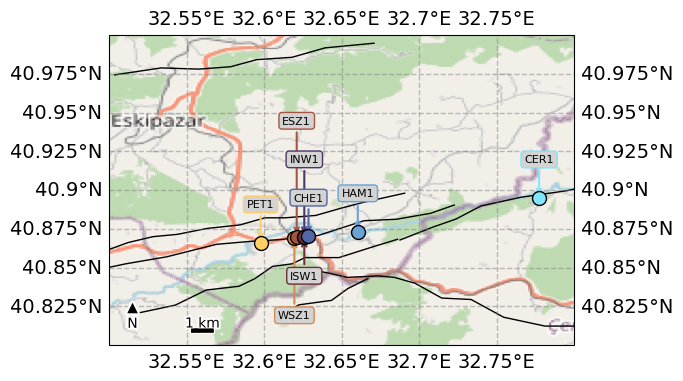

In [27]:
fig = plt.figure(figsize=(6, 6))

axa= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
axa.add_image(osm, 10)  # Zoom level of 8 
axa.set_extent(NAF_extent_inset, crs=ccrs.PlateCarree())
axa.add_geometries(gdf_Asia.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
gl = axa.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
gl.ylabel_style = {'size': 14}
shift='vertical'

for i in range(len(NAF)):
    face_color = color_dict['creepmeter'][NAF['Creepmeter_abbrv'].iloc[i]]
    # Default xytext offset
    if shift == 'horizontal':
        # Adjust xytext for specific creepmeter abbreviations
        if NAF['Creepmeter_abbrv'].iloc[i] in ['XRSW', 'XTA1','XHSW', 'C461','CWN1/CWC3','CRR1','XMM1','QW30','SC30/72/TE']:
            xytext_lon = NAF['Longitude'].iloc[i] - 0.1  # Subtract 0.1 for these specific abbreviations
        else:
            xytext_lon = NAF['Longitude'].iloc[i] + 0.1
        xytext_lat = NAF['Latitude'].iloc[i]
    if shift == 'vertical':
        xytext_lon = NAF['Longitude'].iloc[i] 
        xytext_lat = NAF['Latitude'].iloc[i]+0.025
        if NAF['Creepmeter_abbrv'].iloc[i] in ['WSZ1']:
            xytext_lon = NAF['Longitude'].iloc[i]
            xytext_lat = NAF['Latitude'].iloc[i]-0.05
        if NAF['Creepmeter_abbrv'].iloc[i] in ['ISW1']:
            xytext_lon = NAF['Longitude'].iloc[i]
            xytext_lat = NAF['Latitude'].iloc[i]-0.025
        if NAF['Creepmeter_abbrv'].iloc[i] in ['ESZ1']:
            xytext_lon = NAF['Longitude'].iloc[i]
            xytext_lat = NAF['Latitude'].iloc[i]+0.075
        if NAF['Creepmeter_abbrv'].iloc[i] in ['INW1']:
            xytext_lon = NAF['Longitude'].iloc[i]
            xytext_lat = NAF['Latitude'].iloc[i]+0.05
        
    
    axa.annotate(
        NAF['Creepmeter_abbrv'].iloc[i], 
        xy=(NAF['Longitude'].iloc[i], NAF['Latitude'].iloc[i]),
        xytext=(xytext_lon, xytext_lat), 
        arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
        fontsize=8, ha='center', va='center',
        transform=ccrs.PlateCarree()  # Make sure coordinates are correct
    )
    # Scatter points for creepmeters
    axa.scatter(
        NAF['Longitude'].iloc[i], 
        NAF['Latitude'].iloc[i], 
        color=face_color, 
        edgecolor='black', 
        s=100, 
        zorder=100, 
        transform=ccrs.Geodetic()
    )
scale_bar(axa, ccrs.PlateCarree(), 1)

 

plt.savefig('NAF_map_zoom.pdf')
plt.show()

In [28]:
NAF = cm_locs.drop(cm_locs[cm_locs["Network"]!="NAF"].index)

NAF.sort_values(by='Longitude',inplace=True)
NAF.reset_index(inplace=True,drop=True)
#NAF.drop([0,1],inplace=True)
slicedCM = cmap(np.linspace(0, 1, len(NAF)))

color_dict = {'creepmeter':{'SEL1':rgb2hex(slicedCM[8]),
                            'TEP1':rgb2hex(slicedCM[9]),
                            'PET1':rgb2hex(slicedCM[0]),
                            'WSZ1':rgb2hex(slicedCM[1]),
                            'ESZ1':rgb2hex(slicedCM[2]),
                            'ISW1':rgb2hex(slicedCM[3]),
                            'INW1':rgb2hex(slicedCM[4]),
                            'CHE1':rgb2hex(slicedCM[5]),
                            'HAM1':rgb2hex(slicedCM[6]),
                            'CER1':rgb2hex(slicedCM[7])}}

/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


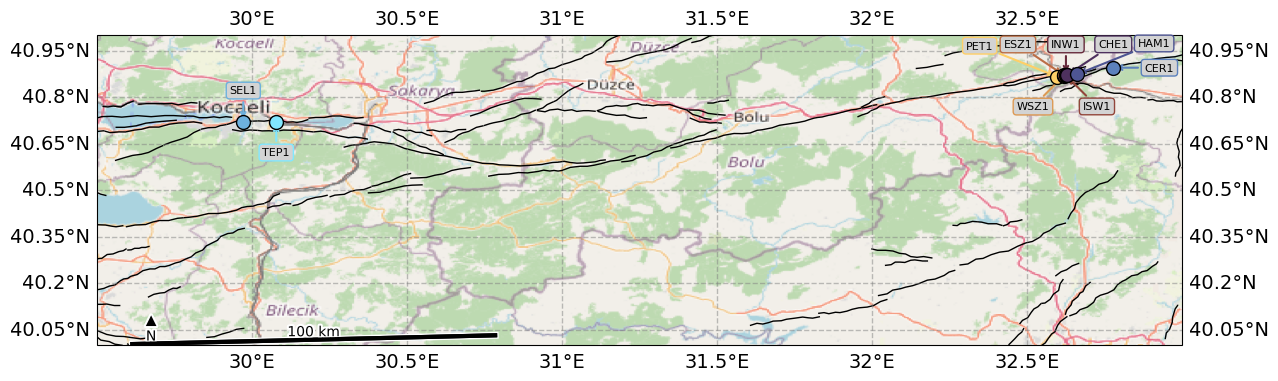

In [29]:
fig = plt.figure(figsize=(14, 14))

axa= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
axa.add_image(osm, 8)  # Zoom level of 8 
axa.set_extent(NAF_extent, crs=ccrs.PlateCarree())
axa.add_geometries(gdf_Asia.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
gl = axa.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
gl.ylabel_style = {'size': 14}
shift='vertical'

for i in range(len(NAF)):
    face_color = color_dict['creepmeter'][NAF['Creepmeter_abbrv'].iloc[i]]
    # Default xytext offset
    if shift == 'horizontal':
        # Adjust xytext for specific creepmeter abbreviations
        if NAF['Creepmeter_abbrv'].iloc[i] in ['XRSW', 'XTA1','XHSW', 'C461','CWN1/CWC3','CRR1','XMM1','QW30','SC30/72/TE']:
            xytext_lon = NAF['Longitude'].iloc[i] - 0.1  # Subtract 0.1 for these specific abbreviations
        else:
            xytext_lon = NAF['Longitude'].iloc[i] + 0.1
        xytext_lat = NAF['Latitude'].iloc[i]
    if shift == 'vertical':
        xytext_lon = NAF['Longitude'].iloc[i] 
        xytext_lat = NAF['Latitude'].iloc[i]+0.1
        if NAF['Creepmeter_abbrv'].iloc[i] in ['TEP1']:
            xytext_lon = NAF['Longitude'].iloc[i]
            xytext_lat = NAF['Latitude'].iloc[i]-0.1
        if NAF['Creepmeter_abbrv'].iloc[i] in ['CER1']:
            xytext_lon = NAF['Longitude'].iloc[i]+0.15
            xytext_lat = NAF['Latitude'].iloc[i]
        if NAF['Creepmeter_abbrv'].iloc[i] in ['HAM1']:
            xytext_lon = NAF['Longitude'].iloc[i]+0.25
            xytext_lat = NAF['Latitude'].iloc[i]+0.1
        if NAF['Creepmeter_abbrv'].iloc[i] in ['CHE1']:
            xytext_lon = NAF['Longitude'].iloc[i]+0.15
            xytext_lat = NAF['Latitude'].iloc[i]+0.1
        if NAF['Creepmeter_abbrv'].iloc[i] in ['PET1']:
            xytext_lon = NAF['Longitude'].iloc[i]-0.25
            xytext_lat = NAF['Latitude'].iloc[i]+0.1
        if NAF['Creepmeter_abbrv'].iloc[i] in ['WSZ1']:
            xytext_lon = NAF['Longitude'].iloc[i]-0.1
            xytext_lat = NAF['Latitude'].iloc[i]-0.1
        if NAF['Creepmeter_abbrv'].iloc[i] in ['ISW1']:
            xytext_lon = NAF['Longitude'].iloc[i]+0.1
            xytext_lat = NAF['Latitude'].iloc[i]-0.1
        if NAF['Creepmeter_abbrv'].iloc[i] in ['ESZ1']:
            xytext_lon = NAF['Longitude'].iloc[i]-0.15
            xytext_lat = NAF['Latitude'].iloc[i]+0.1
        if NAF['Creepmeter_abbrv'].iloc[i] in ['INW1']:
            xytext_lon = NAF['Longitude'].iloc[i]
            xytext_lat = NAF['Latitude'].iloc[i]+0.1
        
    
    axa.annotate(
        NAF['Creepmeter_abbrv'].iloc[i], 
        xy=(NAF['Longitude'].iloc[i], NAF['Latitude'].iloc[i]),
        xytext=(xytext_lon, xytext_lat), 
        arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
        fontsize=8, ha='center', va='center',
        transform=ccrs.PlateCarree()  # Make sure coordinates are correct
    )
    # Scatter points for creepmeters
    axa.scatter(
        NAF['Longitude'].iloc[i], 
        NAF['Latitude'].iloc[i], 
        color=face_color, 
        edgecolor='black', 
        s=100, 
        zorder=100, 
        transform=ccrs.Geodetic()
    )
scale_bar(axa, ccrs.PlateCarree(), 100)


plt.savefig('NAF_map.pdf')


plt.show()

In [30]:
RID = cm_locs.drop(cm_locs[cm_locs["Network"]!="RID"].index)
RID.sort_values(by='Longitude',inplace=True)
RID.reset_index(inplace=True,drop=True)
RID['Creepmeter_abbrv'].iloc[2] = 'RA/RB'
RID.drop([3],inplace=True)
RID.reset_index(inplace=True,drop=True)
RID

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_3879/1021252855.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RID['Creepmeter_abbrv'].iloc[2] = 'RA/RB'


Network Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  Length  \
0     RID        GD Ridgecrest               GD   35.4434  -117.6832     8 m   
1     RID        GT Ridgecrest               GT   35.4695  -117.5919   9.8 m   
2     RID        RA Ridgecrest            RA/RB   35.6189  -117.5722     2 m   
3     RID        GS Ridgecrest               GS   35.5022  -117.4678  10.5 m   
4     RID        R7 Ridgecrest               R7   35.5960  -117.4019     4 m   
5     RID        GB Ridgecrest               GB   35.5239  -117.3731     4 m   

  Depth Obliquity Sensor Type Rod type notes Regular sampling mins Daily  \
0   NaN        30         NaN      NaN   NaN                   Yes   NaN   
1   NaN        30         NaN      NaN   NaN                   Yes   NaN   
2   NaN        30         NaN      NaN   NaN                   Yes    No   
3   NaN        30         NaN      NaN   NaN                   Yes    No   
4   NaN        35         NaN      NaN   NaN                   Yes    No   
5   NaN        30         NaN      NaN   NaN                   Yes    No   

  Manual Temp orthogonal voltage   IR ortho V  
0    NaN  NaN        NaN     NaN  NaN     NaN  
1    NaN  NaN        NaN     NaN  NaN     NaN  
2     No   No         No      No   No      No  
3     No   No         No      No   No      No  
4     No   No         No      No   No      No  
5     No   No         No      No   No      No

In [31]:
cmap = cmc.managua
slicedCM = cmap(np.linspace(0, 1, len(RID)))


color_dict = {'creepmeter':{'GD':rgb2hex(slicedCM[0]),
                            'GT':rgb2hex(slicedCM[1]),
                            'RA/RB':rgb2hex(slicedCM[2]),
                            'GS':rgb2hex(slicedCM[3]),
                            'R7':rgb2hex(slicedCM[4]),
                            'GB':rgb2hex(slicedCM[5])}}

RID_extent = [-118,-117, 35,36]

/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


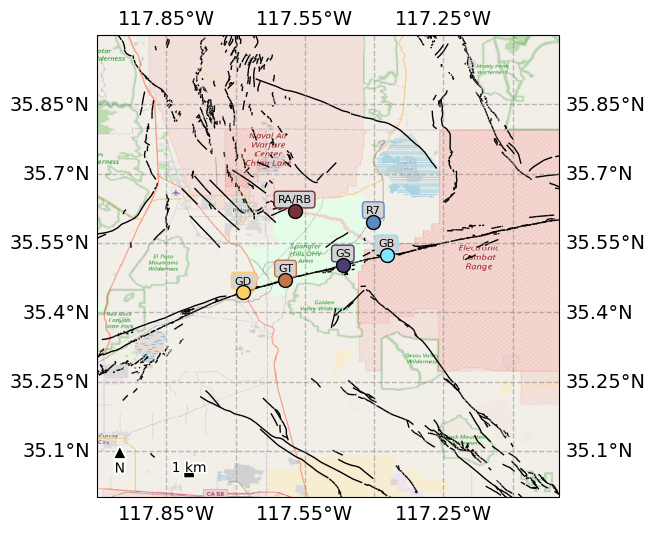

In [32]:
fig = plt.figure(figsize=(6, 6))

axa= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
axa.add_image(osm, 10)  # Zoom level of 8 
axa.set_extent(RID_extent, crs=ccrs.PlateCarree())
axa.add_geometries(gdf_Cali.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
gl = axa.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
gl.ylabel_style = {'size': 14}
shift='vertical'

for i in range(len(RID)):
    face_color = color_dict['creepmeter'][RID['Creepmeter_abbrv'].iloc[i]]
    # Default xytext offset
    if shift == 'horizontal':
        # Adjust xytext for specific creepmeter abbreviations
        if NAF['Creepmeter_abbrv'].iloc[i] in ['XRSW', 'XTA1','XHSW', 'C461','CWN1/CWC3','CRR1','XMM1','QW30','SC30/72/TE']:
            xytext_lon = RID['Longitude'].iloc[i] - 0.1  # Subtract 0.1 for these specific abbreviations
        else:
            xytext_lon = RID['Longitude'].iloc[i] + 0.1
        xytext_lat = RID['Latitude'].iloc[i]
    if shift == 'vertical':
        xytext_lon = RID['Longitude'].iloc[i] 
        xytext_lat = RID['Latitude'].iloc[i]+0.025
        if RID['Creepmeter_abbrv'].iloc[i] in ['WSZ1']:
            xytext_lon = RID['Longitude'].iloc[i]
            xytext_lat = RID['Latitude'].iloc[i]-0.05
        
        
    
    axa.annotate(
        RID['Creepmeter_abbrv'].iloc[i], 
        xy=(RID['Longitude'].iloc[i], RID['Latitude'].iloc[i]),
        xytext=(xytext_lon, xytext_lat), 
        arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
        fontsize=8, ha='center', va='center',
        transform=ccrs.PlateCarree()  # Make sure coordinates are correct
    )
    # Scatter points for creepmeters
    axa.scatter(
        RID['Longitude'].iloc[i], 
        RID['Latitude'].iloc[i], 
        color=face_color, 
        edgecolor='black', 
        s=100, 
        zorder=100, 
        transform=ccrs.Geodetic()
    )
scale_bar(axa, ccrs.PlateCarree(), 1)
plt.savefig('Ridgecrest_map.pdf')
plt.show()

In [33]:
UTA

Network Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude Length  \
0     UTA          Canyonlands             CAN1   38.0198  -110.0374  7.5 m   

  Depth Obliquity Sensor Type Rod type notes Regular sampling mins Daily  \
0   NaN        45         NaN      NaN   NaN                   Yes    No   

  Manual Temp orthogonal voltage  IR ortho V  
0     No  Yes         No      No  No      No

In [34]:
slicedCM = cmap(np.linspace(0, 1, 2))


color_dict = {'creepmeter':{'CAN1':rgb2hex(slicedCM[0])}}

UTA_extent = [-114.2,-108.5, 36.8,42.2]

/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


<urlopen error [Errno 8] nodename nor servname provided, or not known>


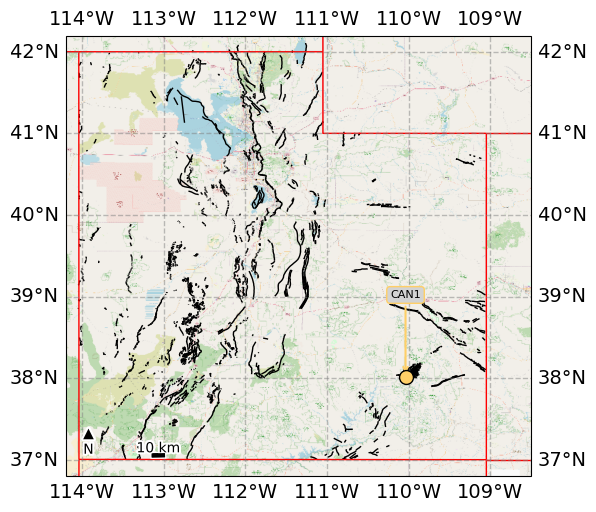

In [35]:
fig = plt.figure(figsize=(6, 6))

axa= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
axa.add_image(osm, 10)  # Zoom level of 8 
axa.set_extent(UTA_extent, crs=ccrs.PlateCarree())
axa.add_geometries(gdf_Utah.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
gl = axa.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
gl.ylabel_style = {'size': 14}
shift='vertical'

# Add state boundaries
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

axa.add_feature(states_provinces, edgecolor='red')

for i in range(len(UTA)):
    face_color = color_dict['creepmeter'][UTA['Creepmeter_abbrv'].iloc[i]]
    # Default xytext offset
    if shift == 'horizontal':
        # Adjust xytext for specific creepmeter abbreviations
        xytext_lon = UTA['Longitude'].iloc[i] + 0.5
        xytext_lat = UTA['Latitude'].iloc[i]
    if shift == 'vertical':
        xytext_lon = UTA['Longitude'].iloc[i] 
        xytext_lat = UTA['Latitude'].iloc[i]+1
        if RID['Creepmeter_abbrv'].iloc[i] in ['WSZ1']:
            xytext_lon = UTA['Longitude'].iloc[i]
            xytext_lat = UTA['Latitude'].iloc[i]-0.05
        
        
    
    axa.annotate(
        UTA['Creepmeter_abbrv'].iloc[i], 
        xy=(UTA['Longitude'].iloc[i], UTA['Latitude'].iloc[i]),
        xytext=(xytext_lon, xytext_lat), 
        arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
        fontsize=8, ha='center', va='center',
        transform=ccrs.PlateCarree()  # Make sure coordinates are correct
    )
    # Scatter points for creepmeters
    axa.scatter(
        UTA['Longitude'].iloc[i], 
        UTA['Latitude'].iloc[i], 
        color=face_color, 
        edgecolor='black', 
        s=100, 
        zorder=100, 
        transform=ccrs.Geodetic()
    )
scale_bar(axa, ccrs.PlateCarree(), 10)
plt.savefig('Utah_map.pdf')
plt.show()

In [36]:
slicedCM = cmap(np.linspace(0, 1, 2))


color_dict = {'creepmeter':{'CHA1':rgb2hex(slicedCM[0])}}



/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


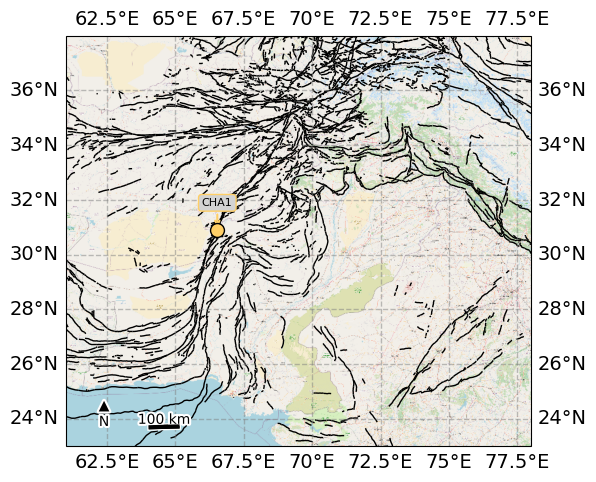

In [37]:
fig = plt.figure(figsize=(6, 6))

axa= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
axa.add_image(osm, 8)  # Zoom level of 8 
axa.set_extent(pakistan_extent, crs=ccrs.PlateCarree())
axa.add_geometries(gdf_Asia.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
gl = axa.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
gl.ylabel_style = {'size': 14}
shift='vertical'

for i in range(len(CHAF)):
    face_color = color_dict['creepmeter'][CHAF['Creepmeter_abbrv'].iloc[i]]
    # Default xytext offset
    if shift == 'horizontal':
        # Adjust xytext for specific creepmeter abbreviations
        xytext_lon = CHAF['Longitude'].iloc[i] + 0.5
        xytext_lat = CHAF['Latitude'].iloc[i]
    if shift == 'vertical':
        xytext_lon = CHAF['Longitude'].iloc[i] 
        xytext_lat = CHAF['Latitude'].iloc[i]+1
        if RID['Creepmeter_abbrv'].iloc[i] in ['WSZ1']:
            xytext_lon = CHAF['Longitude'].iloc[i]
            xytext_lat = CHAF['Latitude'].iloc[i]-0.05
        
        
    
    axa.annotate(
        CHAF['Creepmeter_abbrv'].iloc[i], 
        xy=(CHAF['Longitude'].iloc[i], CHAF['Latitude'].iloc[i]),
        xytext=(xytext_lon, xytext_lat), 
        arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
        fontsize=8, ha='center', va='center',
        transform=ccrs.PlateCarree()  # Make sure coordinates are correct
    )
    # Scatter points for creepmeters
    axa.scatter(
        CHAF['Longitude'].iloc[i], 
        CHAF['Latitude'].iloc[i], 
        color=face_color, 
        edgecolor='black', 
        s=100, 
        zorder=100, 
        transform=ccrs.Geodetic()
    )
scale_bar(axa, ccrs.PlateCarree(), 100)
plt.savefig('Pakistan_map.pdf')
plt.show()

In [38]:
HOL.sort_values(by='Latitude',inplace=True)
HOL.reset_index(inplace=True,drop=True)
HOL

Network       Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  \
0     HOL              Melendy Ranch             XMR1   36.5950 -121.18700   
1     HOL                  Fox Creek             FXC1   36.6925 -121.30610   
2     HOL     Cienega Winery Central        CWN1/CWC3   36.7500 -121.38500   
3     HOL               Harris Ranch         XHR1/2/3   36.7720 -121.42200   
4     HOL       San Juan Bautista #2           XSJ2/3   36.8360 -121.52100   
5     HOL  San Juan Bautista, Nyland             SJN1   36.8546 -121.54673   
6     CAL                Shore Rd #1             XSH1   36.9430 -121.44500   

  Length Depth           Obliquity                   Sensor Type  \
0   10 m    cm                  30  USGS standard, now Bilham #2   
1    NaN   NaN                 NaN                           NaN   
2  15 cm   NaN                   0                     15cm beam   
3   30 m   NaN                  22                 USGS standard   
4   20 m   1 m                  30                 USGS standard   
5   15 m   NaN  30 (originally 45)                          LVDT   
6   14 m   NaN                41.5                 USGS standard   

                      Rod type notes Regular sampling mins Daily Manual Temp  \
0   invar now carbon fiber rod   NaN                   Yes   Yes    Yes   No   
1                          NaN   NaN                   Yes    No     No  Yes   
2                         beam   NaN                   Yes   Yes    Yes   No   
3                          NaN   NaN                   Yes    No    Yes   No   
4                          NaN   NaN                   Yes   Yes    Yes   No   
5  Carbon rod previsouly invar   NaN                   Yes    No     No   No   
6                          NaN   NaN                   Yes   Yes    Yes   No   

  orthogonal voltage  IR ortho V  
0         No      No  No      No  
1        Yes      No  No      No  
2         No      No  No      No  
3         No      No  No      No  
4         No      No  No      No  
5         No      No  No      No  
6         No      No  No      No

In [39]:
slicedCM = cmap(np.linspace(0, 1, len(HOL)))


color_dict = {'creepmeter':{'XSH1':rgb2hex(slicedCM[0]),
                            'SJN1':rgb2hex(slicedCM[1]),
                            'XSJ2/3':rgb2hex(slicedCM[2]),
                            'XHR1/2/3':rgb2hex(slicedCM[3]),
                            'CWN1/CWC3':rgb2hex(slicedCM[4]),
                            'FXC1':rgb2hex(slicedCM[5]),
                            'XMR1':rgb2hex(slicedCM[6])}}

/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


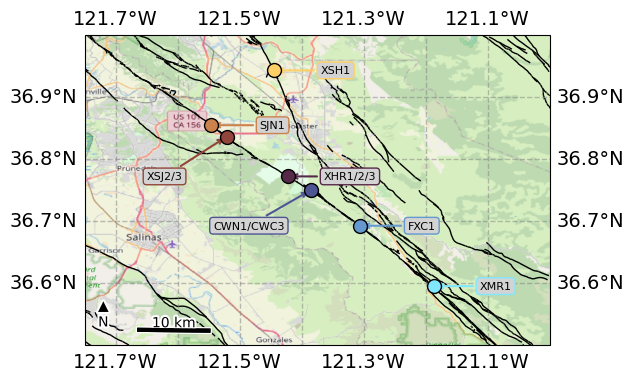

In [40]:
fig = plt.figure(figsize=(6, 6))

axa= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
axa.add_image(osm, 10)  # Zoom level of 8 
axa.set_extent(hollister_extent, crs=ccrs.PlateCarree())
axa.add_geometries(gdf_Cali.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
gl = axa.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
gl.ylabel_style = {'size': 14}
shift='horizontal'

for i in range(len(HOL)):
    face_color = color_dict['creepmeter'][HOL['Creepmeter_abbrv'].iloc[i]]
    # Default xytext offset
    if HOL['Creepmeter_abbrv'].iloc[i] in ['XRSW', 'XTA1','XHSW', 'C461','CWN1/CWC3','CRR1','XMM1','XSJ2/3']:
        xytext_lon = HOL['Longitude'].iloc[i] - 0.1  # Subtract 0.1 for these specific abbreviations
    else:
        xytext_lon = HOL['Longitude'].iloc[i] + 0.1
        xytext_lat = HOL['Latitude'].iloc[i]
    if shift == 'vertical':
        xytext_lon = HOL['Longitude'].iloc[i] 
        xytext_lat = HOL['Latitude'].iloc[i]+1
        
        
    
    axa.annotate(
        HOL['Creepmeter_abbrv'].iloc[i], 
        xy=(HOL['Longitude'].iloc[i], HOL['Latitude'].iloc[i]),
        xytext=(xytext_lon, xytext_lat), 
        arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
        fontsize=8, ha='center', va='center',
        transform=ccrs.PlateCarree()  # Make sure coordinates are correct
    )
    # Scatter points for creepmeters
    axa.scatter(
        HOL['Longitude'].iloc[i], 
        HOL['Latitude'].iloc[i], 
        color=face_color, 
        edgecolor='black', 
        s=100, 
        zorder=100, 
        transform=ccrs.Geodetic()
    )
scale_bar(axa, ccrs.PlateCarree(), 10)
plt.savefig('Hollister_map.pdf')
plt.show()

In [41]:
slicedCM = cmap(np.linspace(0, 1, len(HAY)))
HAY.sort_values(by='Latitude',inplace=True)
HAY.reset_index(inplace=True,drop=True)
HAY

Network     Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  \
0     HAY           Fremont Winery             CFW1    37.532   -121.952   
1     HAY  Hayward Palisades St #2             CHP1    37.663   -122.074   
2     HAY              Oakland Zoo             COZ1    37.753   -122.150   
3     HAY                 Temescal             CTM1    37.844   -122.227   
4     HAY                Pt Pinole             CPP1    37.990   -122.356   

  Length  Depth Obliquity Sensor Type  \
0   25 m    1 m        30        LVDT   
1   20 m    1 m        30        LVDT   
2   30 m  1.5 m        30        LVDT   
3   30 m    1 m        30        LVDT   
4   30 m   2  m        30        LVDT   

                                            Rod type notes  \
0  silica-glass fiber and invar (two separate int...   NaN   
1                              invar now glass fiber   NaN   
2                             glass and carbon fiber   NaN   
3                            Invar, now carbon fiber   NaN   
4  Initially Invar. Changed to 5mm diameter carbo...   NaN   

  Regular sampling mins Daily Manual Temp orthogonal voltage  IR ortho V  
0                   Yes    No     No   No         No      No  No      No  
1                   Yes    No     No   No         No      No  No      No  
2                   Yes    No     No   No         No      No  No      No  
3                   Yes    No     No   No         No      No  No      No  
4                   Yes    No     No   No         No      No  No      No

In [42]:
color_dict = {'creepmeter':{'CPP1':rgb2hex(slicedCM[0]),
                            'CTM1':rgb2hex(slicedCM[1]),
                            'COZ1':rgb2hex(slicedCM[2]),
                            'CHP1':rgb2hex(slicedCM[3]),
                            'CFW1':rgb2hex(slicedCM[4])}}

/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


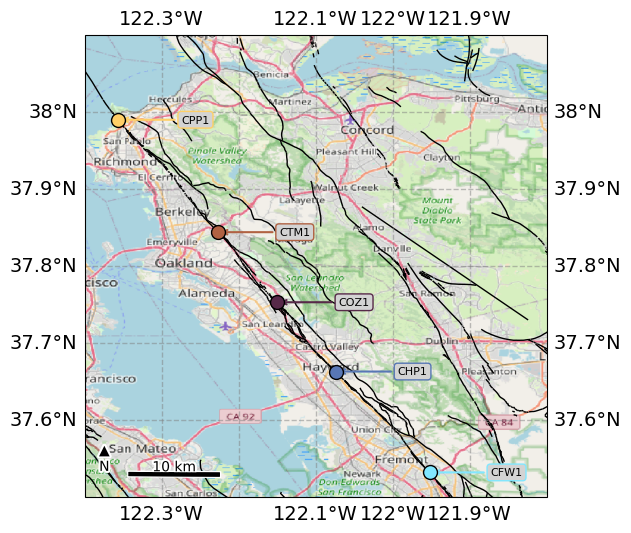

In [43]:
fig = plt.figure(figsize=(6, 6))

axa= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
axa.add_image(osm, 10)  # Zoom level of 8 
axa.set_extent(hayward_extent, crs=ccrs.PlateCarree())
axa.add_geometries(gdf_Cali.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
gl = axa.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
gl.ylabel_style = {'size': 14}
shift='horizontal'

for i in range(len(HAY)):
    face_color = color_dict['creepmeter'][HAY['Creepmeter_abbrv'].iloc[i]]
    # Default xytext offset
    xytext_lon = HAY['Longitude'].iloc[i] + 0.1  # Subtract 0.1 for these specific abbreviations
    xytext_lat = HAY['Latitude'].iloc[i]

        
        
    
    axa.annotate(
        HAY['Creepmeter_abbrv'].iloc[i], 
        xy=(HAY['Longitude'].iloc[i], HAY['Latitude'].iloc[i]),
        xytext=(xytext_lon, xytext_lat), 
        arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
        fontsize=8, ha='center', va='center',
        transform=ccrs.PlateCarree()  # Make sure coordinates are correct
    )
    # Scatter points for creepmeters
    axa.scatter(
        HAY['Longitude'].iloc[i], 
        HAY['Latitude'].iloc[i], 
        color=face_color, 
        edgecolor='black', 
        s=100, 
        zorder=100, 
        transform=ccrs.Geodetic()
    )
scale_bar(axa, ccrs.PlateCarree(), 10)
plt.savefig('Hayward_map.pdf')
plt.show()

In [44]:
slicedCM = cmap(np.linspace(0, 1, len(PARK)))
PARK.sort_values(by='Latitude',inplace=True)
PARK.reset_index(inplace=True,drop=True)
PARK

Network Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  Length  \
0     PARK           Highway 46             X461    35.723   -120.278    27 m   
1     PARK           Highway 46           C461/2    35.724   -120.282     NaN   
2     PARK            Gold Hill             XGH1    35.820   -120.348    10 m   
3     PARK           Carr Ranch             CRR1    35.835   -120.363   9.4 m   
4     PARK           Work Ranch             WKR1    35.858   -120.392    14 m   
5     PARK     Hearst, SW trace             XHSW    35.862   -120.420    30 m   
6     PARK         Taylor Ranch             XTA1    35.890   -120.427    30 m   
7     PARK         Parkfield #1           XPK1/2    35.902   -120.442    23 m   
8     PARK   Roberson, SW trace             XRSW    35.907   -120.460    30 m   
9     PARK               Varian             XVA1    35.922   -120.462    30 m   
10    PARK         Middle Ridge             XMD1    35.943   -120.485    36 m   
11    PARK           Middle Mtn             XMM1    35.958   -120.502    26 m   
12    PARK        Slacks Canyon             XSC1    36.065   -120.628    10 m   

   Depth Obliquity     Sensor Type Rod type                       notes  \
0    1 m       -44   USGS standard      NaN  contraction is dexral slip   
1    NaN        30       Bilham #1    Invar                         NaN   
2     cm        30   USGS standard     wire                         NaN   
3    1 m        45  Caltech Design     wire                         NaN   
4    1 m        45  Caltech Design     wire                         NaN   
5    NaN        45   USGS standard     wire                         NaN   
6    1 m        30   USGS standard     wire                         NaN   
7    1 m        30   USGS standard     wire                         NaN   
8    NaN        30   USGS standard     wire                         NaN   
9    1 m        30   USGS standard     wire                         NaN   
10   1 m        27   USGS standard     wire                         NaN   
11   1 m        30   USGS standard     wire                         NaN   
12    cm        27   USGS standard     wire                         NaN   

   Regular sampling mins Daily Manual Temp orthogonal voltage  IR ortho V  
0                    Yes   Yes    Yes   No         No      No  No      No  
1                    Yes    No     No   No         No      No  No      No  
2                    Yes   Yes    Yes   No         No      No  No      No  
3                    Yes   Yes    Yes   No         No      No  No      No  
4                    Yes   Yes    Yes   No         No      No  No      No  
5                    Yes   Yes    Yes   No         No      No  No      No  
6                    Yes   Yes    Yes   No         No      No  No      No  
7                    Yes   Yes    Yes   No         No      No  No      No  
8                    Yes   Yes    Yes   No         No      No  No      No  
9                    Yes   Yes    Yes   No         No      No  No      No  
10                   Yes   Yes    Yes   No         No      No  No      No  
11                   Yes   Yes    Yes   No         No      No  No      No  
12                   Yes   Yes    Yes   No         No      No  No      No

In [45]:
color_dict = {'creepmeter':{'XSC1':rgb2hex(slicedCM[0]),
                            'XMM1':rgb2hex(slicedCM[1]),
                            'XMD1':rgb2hex(slicedCM[2]),
                            'XVA1':rgb2hex(slicedCM[3]),
                            'XRSW':rgb2hex(slicedCM[4]),
                            'XPK1/2':rgb2hex(slicedCM[5]),
                            'XPK1':rgb2hex(slicedCM[5]),
                            'XPK2':rgb2hex(slicedCM[5]),
                            'XTA1':rgb2hex(slicedCM[6]),
                            'XHSW':rgb2hex(slicedCM[7]),
                            'WKR1':rgb2hex(slicedCM[8]),
                            'CRR1':rgb2hex(slicedCM[9]),
                            'XGH1':rgb2hex(slicedCM[10]),
                            'C461/2':rgb2hex(slicedCM[11]),
                            'X461':rgb2hex(slicedCM[12])}}


/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


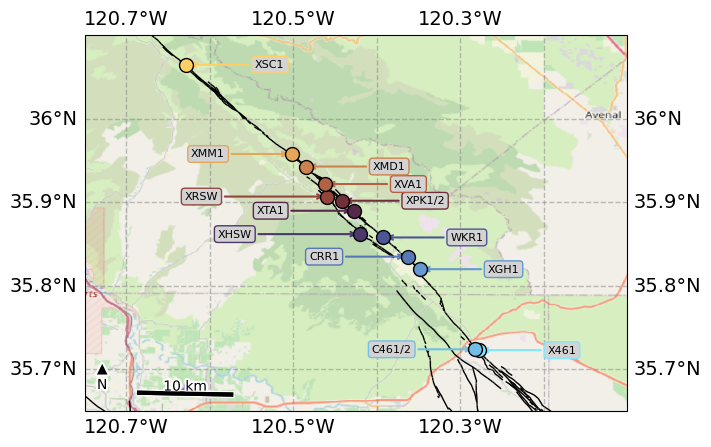

In [46]:
fig = plt.figure(figsize=(7, 7))

axa= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
axa.add_image(osm, 10)  # Zoom level of 8 
axa.set_extent(parkfield_extent, crs=ccrs.PlateCarree())
axa.add_geometries(gdf_Cali.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
gl = axa.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
gl.ylabel_style = {'size': 14}
shift='horizontal'

for i in range(len(PARK)):
    face_color = color_dict['creepmeter'][PARK['Creepmeter_abbrv'].iloc[i]]
    # Default xytext offset
    if PARK['Creepmeter_abbrv'].iloc[i] in ['XTA1', 'C461/2','CWN1/CWC3','CRR1','XMM1','XSJ2/3']:
        xytext_lon = PARK['Longitude'].iloc[i] - 0.1  # Subtract 0.1 for these specific abbreviations
        xytext_lat = PARK['Latitude'].iloc[i]
    elif PARK['Creepmeter_abbrv'].iloc[i] in ['XHSW']:
        xytext_lon = PARK['Longitude'].iloc[i] - 0.15
        xytext_lat = PARK['Latitude'].iloc[i]
    elif PARK['Creepmeter_abbrv'].iloc[i] in ['XRSW']:
        xytext_lon = PARK['Longitude'].iloc[i] - 0.15
        xytext_lat = PARK['Latitude'].iloc[i]
    else:
        xytext_lon = PARK['Longitude'].iloc[i] + 0.1
        xytext_lat = PARK['Latitude'].iloc[i]
        
        
    
    axa.annotate(
        PARK['Creepmeter_abbrv'].iloc[i], 
        xy=(PARK['Longitude'].iloc[i], PARK['Latitude'].iloc[i]),
        xytext=(xytext_lon, xytext_lat), 
        arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
        fontsize=8, ha='center', va='center',
        transform=ccrs.PlateCarree()  # Make sure coordinates are correct
    )
    # Scatter points for creepmeters
    axa.scatter(
        PARK['Longitude'].iloc[i], 
        PARK['Latitude'].iloc[i], 
        color=face_color, 
        edgecolor='black', 
        s=100, 
        zorder=100, 
        transform=ccrs.Geodetic()
    )
scale_bar(axa, ccrs.PlateCarree(), 10)
plt.savefig('Parkfield_map.pdf')
plt.show()